# Perform "phasing" analyses on a region within a sequence

In this case, within a single gene within the CAMP genome.

In [1]:
%run "Header.ipynb"

In [2]:
%run "LoadMutationJSONData.ipynb"

In [1]:
import statistics
import scipy
import pysam
import skbio
from itertools import combinations

ModuleNotFoundError: No module named 'pysam'

## Find all reads spanning this gene
Note that reads could in theory have lots of mismatches, deletions, etc. in the middle of their alignments to this gene -- I think this is ok, since we've already filtered partially-mapped reads.

In [ ]:
bf = pysam.AlignmentFile("../main-workflow/output/fully-filtered-and-sorted-aln.bam", "rb")

# The gene's coordinates (1-indexed), as output by Prodigal, are
# [1,208,927, 1,210,075] (that's an inclusive range -- you can check that our
# interpretation of these coordinates is correct by comparing the protein
# sequences accompanying this gene predicted by Prodigal with the actual
# CAMP sequence -- it's clear that the codons match up).
#
# For 0-indexing in Python / Pysam notation, we represent this as
# [1,208,926, 1,210,075) -- Python / Pysam end coordinates are not included,
# so this really ranges to 1,210,074.
g1 = (1208926, 1210075)

# Figure out all reads that completely span this gene (i.e. they are aligned
# to start at or "before" the start of the gene, and they are aligned to end
# at or "after" the end of the gene).
spanning_reads = []
for read in bf.fetch("edge_6104", g1[0], g1[1]):
    # fetch() returns all reads that are incident on a region, but this
    # includes reads that don't fully cover the region. Hence our checking that
    # the read covers the gene on both sides (it doesn't start and/or end
    # within the middle of the gene).
    read_pos = read.get_reference_positions()
    if read_pos[0] <= g1[0] and read_pos[-1] >= g1[1] - 1:
        spanning_reads.append(read)

print("{} spanning reads.".format(len(spanning_reads)))
        
# Double-check that no read names are duplicated in the spanning reads -- this could
# happen in theory if a given read has multiple supplementary alignments within this
# region, I suppose. (The fetch() function in Pysam technically returns an AlignedSegment,
# not a "read" -- since a read can be associated with multiple AlignedSegments in the case
# of supplementary alignments.)
#
# If any reads were to occur twice here, it probably wouldn't change much in our
# interpretation (I suppose it would introduce some bias in our statistics) -- to make
# sleeping at night easier, it's useful to be able to say confidently that all of the
# spanning reads we analyze here contain no duplicates. Hence this check!
read_names = [r.query_name for r in spanning_reads]
if len(set(read_names)) != len(read_names):
    raise ValueError(
        "It looks like there are some duplicated 'spanning reads' in the G1 phasing analysis."
    )

## Find all notably "mutated" positions in this gene

In [ ]:
# "brevity is the soul of wit, but specificity is the soul of not writing code
# that you forget about one week later" -- definitely shakespeare
LOWER_CUTOFF_FOR_WHAT_CONSTITUTES_A_MUTATED_POSITION_HERE = 0.14

mutated_positions = []
for pos in range(g1[0], g1[1]):
    # Keep in mind that the JSONs use string, 1-indexed coordinates, while Pysam (generally)
    # uses Python-style 0-indexed coordinates
    spos = str(pos + 1)
    if seq2pos2totalcov["edge_6104"][spos] > 0:
        matches = seq2pos2matchct["edge_6104"][spos]
        mismatches = seq2pos2mismatchct["edge_6104"][spos]
        if mismatches / (matches + mismatches) > LOWER_CUTOFF_FOR_WHAT_CONSTITUTES_A_MUTATED_POSITION_HERE:
            mutated_positions.append(pos)

num_mut_pos = len(mutated_positions)
            
print(
    "{} mutated positions, using cutoff of {}.".format(
        num_mut_pos,
        LOWER_CUTOFF_FOR_WHAT_CONSTITUTES_A_MUTATED_POSITION_HERE
    )
)

## Figure out how many reads spanning the gene support pairs of mutations in particularly "mutated" positions

This performs the (main) analysis described in the section "Phasing gene G1" of the paper.

In [ ]:
# Extract the reference sequence of the gene. This will let us figure out
# easily (ish) which reads are mutated at which positions.
camp = skbio.DNA.read("../main-workflow/output/edge_6104.fasta")
geneseq = camp[g1[0]:g1[1]]

# Go through all pairs of N mutated positions (ignoring ordering). There'll
# be (N choose 2) pairs to go through.
num_pairs = scipy.special.comb(num_mut_pos, 2)
print(
    "{} choose 2 = {} pairs of the {} mutated positions.".format(
        num_mut_pos, num_pairs, num_mut_pos
    )
)

num_bothmutated_reads_across_all_mutated_pos_pairs = []
ii = 1
for mpospair in combinations(mutated_positions, 2):
    # Save the mutated positions in easier-to-handle variables.
    p0, p1 = mpospair

    # Do some basic sanity-checking -- this'll help us as we
    # iterate through reads below.
    if p0 == p1: raise ValueError("p0 should never equal p1")
    if p0 > p1: raise ValueError("p0 should be < p1")

    # Find out the reference nucleotides at p0 and at p1.
    p0ref = str(camp[p0])
    p1ref = str(camp[p1])
    print(
        "Pair {} / {}. Ref p0 = {}, p1 = {}; p0 = {}, p1 = {}".format(
            ii, num_pairs, p0, p1, p0ref, p1ref
        )
    )
    
    # Figure out how many spanning reads have mutations at BOTH p0 and p1.
    num_bothmutated_reads = 0
    num_reads_that_didnt_skip_either_position = 0
    for read in spanning_reads:
        # Figure out where, exactly, in this read was aligned to p0 and p1.
        # (Oh, and for clarity -- the first element in each aligned pairs tuple
        # is the read position, and the second element is the reference position.
        # It's not explicitly stated in Pysam's docs.)
        ap = read.get_aligned_pairs()
        query_pos_aligned_to_p0 = None
        query_pos_aligned_to_p1 = None
        for pair in ap:
            # (... this assumes that p0 will never equal p1. that'd be bad. we've
            # guaranteed this above.)
            if pair[1] == p0:
                query_pos_aligned_to_p0 = pair[0]
            elif pair[1] == p1:
                query_pos_aligned_to_p1 = pair[0]
                # relies on p0 < p1, which we've guaranteed above;
                # this break statement lets us avoid unnecessary iteration
                break
                
        # If this read wasn't aligned to either or both of these positions
        # (could be due to deletions, etc.) then just ignore this read.
        if query_pos_aligned_to_p0 is None or query_pos_aligned_to_p1 is None:
            continue
            
        # Now that we know the exact positions in this read that were aligned
        # to p0 and p1, extract the nucleotides at these positions in the read
        p0query = read.query_sequence[query_pos_aligned_to_p0]
        p1query = read.query_sequence[query_pos_aligned_to_p1]
        
        # Does the read disagree at BOTH positions?
        if p0query != p0ref and p1query != p1ref:
            # (for debugging)
            #print("Disagreement! Read name = {}".format(read.query_name))
            #print("Read p0 pos = {}, seq = {}".format(query_pos_aligned_to_p0, p0query))
            #print("Read p1 pos = {}, seq = {}".format(query_pos_aligned_to_p1, p1query))
            num_bothmutated_reads += 1
        
        # In any case, we did consider this read in the context of this pair of positions,
        # at least.
        num_reads_that_didnt_skip_either_position += 1
        
    num_bothmutated_reads_across_all_mutated_pos_pairs.append(
        num_bothmutated_reads
    )
    print(
        "Pair of mutations {} had {} reads mutated at both p0 and p1.".format(
            mpospair, num_bothmutated_reads
        )
    )
    print(
        "...Also, {} / {} spanning reads were aligned to both p0 and p1.".format(
            num_reads_that_didnt_skip_either_position, len(spanning_reads)
        )
    )
    ii += 1

print("Average # of both-mutated reads across all mutated position pairs: {}".format(statistics.mean(num_bothmutated_reads_across_all_mutated_pos_pairs)))
print("Std. dev. of both-mutated reads across all mutated position pairs: {}".format(statistics.pstdev(num_bothmutated_reads_across_all_mutated_pos_pairs)))

## Create a histogram of the number of reads with a given number of mutations within a gene

Intended to emphasize the "binary" nature of the mutation spectra.

We can reuse a lot of the results from above (e.g. spanning reads) here.

In [1]:
num_mutations_in_gene_per_spanning_read = []
for read in spanning_reads:
    num_mutations_in_gene = 0
    ap = read.get_aligned_pairs()
    for pair in ap:
        if pair[1] in range(g1[0], g1[1]) and pair[0] is not None:
            query_pos = pair[0]
            query_seq = read.query_sequence[query_pos]
            ref_seq = str(camp[pair[1]])
            if query_seq != ref_seq:
                num_mutations_in_gene += 1
    num_mutations_in_gene_per_spanning_read.append(num_mutations_in_gene)
    
read_mp_cts = sorted(num_mutations_in_gene_per_spanning_read)

NameError: name 'skbio' is not defined

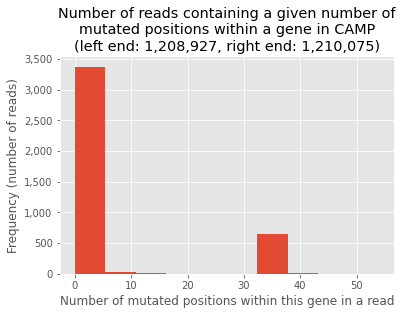

In [14]:
pyplot.hist(read_mp_cts)
pyplot.title(
    (
        "Number of reads containing a given number of\n"
        "mutated positions within a gene in {}\n"
        "(left end: {:,}, right end: {:,})"
    ).format(
        seq2name["edge_6104"], g1[0] + 1, g1[1]
    )
)
use_thousands_sep(pyplot.gca().get_yaxis())
pyplot.ylabel("Frequency (number of reads)")
pyplot.xlabel("Number of mutated positions within this gene in a read")
pyplot.savefig("figs/g1-read-mutation-histogram.png", bbox_inches="tight")

In [15]:
# Heeding the wisdom of https://stackoverflow.com/a/2600208
# ... it's been a long night
from collections import Counter
c = Counter(read_mp_cts)
geq_32_ct = 0
for num_mutated_positions in c.keys():
    print("{} reads have {} mutated positions within the gene.".format(
        c[num_mutated_positions], num_mutated_positions
    ))
    if num_mutated_positions >= 32:
        geq_32_ct += c[num_mutated_positions]
print("ALSO: {} reads total have >= 32 mutated positions within the gene.".format(geq_32_ct))

3023 reads have 0 mutated positions within the gene.
172 reads have 1 mutated positions within the gene.
86 reads have 2 mutated positions within the gene.
53 reads have 3 mutated positions within the gene.
26 reads have 4 mutated positions within the gene.
16 reads have 5 mutated positions within the gene.
11 reads have 6 mutated positions within the gene.
9 reads have 7 mutated positions within the gene.
4 reads have 8 mutated positions within the gene.
1 reads have 9 mutated positions within the gene.
1 reads have 10 mutated positions within the gene.
2 reads have 11 mutated positions within the gene.
3 reads have 12 mutated positions within the gene.
1 reads have 13 mutated positions within the gene.
1 reads have 16 mutated positions within the gene.
1 reads have 18 mutated positions within the gene.
1 reads have 19 mutated positions within the gene.
1 reads have 32 mutated positions within the gene.
34 reads have 33 mutated positions within the gene.
567 reads have 34 mutated posi